In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import sys
import os

In [2]:
def batch_gen():
    with open(file_path) as f:
        for index, line in enumerate(f):
            yield index, line

In [3]:
def correct_timestep(ti):
    new_ti = list()
    for i in range(0, len(ti)):
        new_ti.append(ti[i] - (9*i))
    return new_ti

In [4]:
def min_ip(inflection_points):
    remove_list = list()
    for ip in range(0, len(inflection_points)):
        if inflection_points[ip] < 0:
            remove_list.append(ip)
    if not remove_list:
        ip_pos = inflection_points
    else:
        remove_arr = np.asarray(remove_list)
        ip_pos = np.delete(inflection_points, remove_arr)
    return min(ip_pos)

In [5]:
def find_values(x_data, ip):
    index = (np.abs(x_data-ip)).argmin()
    return np.unique(x_data[index])

In [6]:
def find_index(x_data, ip):
    index = (np.abs(x_data-ip)).argmin()
    return index

In [7]:
def make_array(array):
    new_list = list()
    for arr_sel in range(0, len(array)):
        new_list.append(array[arr_sel][0])
    new_arr = np.asarray(new_list)
    return new_arr

In [8]:
def return_slope(x, y):
    m = (((statistics.mean(x)*statistics.mean(y)) - statistics.mean(x*y))/((statistics.mean(x)*statistics.mean(x)) - statistics.mean(x*x)))
    return m

In [9]:
while True:
    try:
        n_bins = int(input('Enter number of bins: '))
    except ValueError:
        print('Enter a positive whole number')
    if n_bins <= 0:
        print('Enter a positive whole number')
        continue
    else:
        break

Enter number of bins: 250


In [10]:
folder_path = r'C:/Users/krist/Research/'
file = 'dump.baras_restart_reaction_15.9nm_1.34'
file_path = os.path.join(folder_path, file)

In [11]:
timestep_index = list()
x_data = list()
y_data = list()
z_data = list()
c_ke = list()
skip = 0
x = 0

instance = batch_gen()
while True:
    try:
        content = [next(instance) for i in range(0, 100)]
    except:
        break
    for line in range(0, len(content)):
        if skip != 0:
            skip = skip - 1
            continue
        if 'TIMESTEP' in str(content[line][1]):
            timestep_index.append(content[line][0])
            skip = 1
            continue
        elif 'NUMBER OF ATOMS' in str(content[line][1]):
            skip = 1
            continue
        elif 'BOX BOUNDS' in str(content[line][1]):
            skip = 3
            continue
        elif 'ITEM: ATOMS' in str(content[line][1]):
            continue
        else:
            data_strip = content[line][1].strip('\n')
            cat_split = data_strip.split()
            x_data.append(float(cat_split[2]))
            #y_data.append(float(cat_split[3]))
            #z_data.append(float(cat_split[4]))
            c_ke.append(float(cat_split[5]))
            content.append(data_strip)

In [12]:
correct_ti = correct_timestep(timestep_index)

In [13]:
min_x = list()
max_x = list()
for i in range(0, len(correct_ti)):
    if i == len(correct_ti) - 1:
        min_x.append(min(x_data[correct_ti[i]:]))
        max_x.append(max(x_data[correct_ti[i]:]))
    else:
        min_x.append(min(x_data[correct_ti[i]:correct_ti[i+1]]))
        max_x.append(max(x_data[correct_ti[i]:correct_ti[i+1]]))

In [14]:
x_arr = np.asarray(x_data)
temp_arr = np.asarray(c_ke)
data_arr = np.column_stack((x_arr, c_ke))

In [15]:
x_bin_arr = np.zeros((n_bins, 8), dtype = float)
temp_bin_arr = np.zeros((n_bins, 8), dtype = float)
final_values = list()
x_select_list = list()
temp_select_list = list()
row = -1

for i in range(5, 20, 2): #len(correct_ti)):
    row = row + 1
    total_length = max_x[i] - min_x[i]
    bin_length = total_length/n_bins
    correct_data_arr = data_arr[correct_ti[i]:correct_ti[i+1]]
    data_sort_arr = correct_data_arr[correct_data_arr[:, 0].argsort()]
    for binning in range(0, n_bins):
        high = find_index(data_sort_arr[:, 0], (binning + 1)*bin_length + min_x[i])
        low = find_index(data_sort_arr[:, 0], (binning*bin_length) + min_x[i])
        for select_points in data_sort_arr[low:high]:
            x_select_list.append(select_points[0])
            temp_select_list.append(select_points[1])
        
        avg_x = statistics.mean(x_select_list)
        avg_temp = statistics.mean(temp_select_list)
        x_bin_arr[binning, row] = avg_x
        temp_bin_arr[binning, row] = avg_temp
        x_select_list.clear()
        temp_select_list.clear()

    coefs = np.polyfit(x_bin_arr[:, row], temp_bin_arr[:, row], 5)
    x_bin_arr_fit = np.linspace(x_bin_arr[0, row], x_bin_arr[-1, row], len(x_bin_arr[:, row]))
    poly_fit = np.polyval(coefs, x_bin_arr_fit)
    #plt.plot(x_bin_arr_fit, poly_fit)

    poly_fit_d2 = np.polyder(coefs, 2)
    x_bin_arr_fit2 = np.linspace(x_bin_arr[0, row], x_bin_arr[-1, row], len(x_bin_arr[:, row]))
    poly_fit2 = np.polynomial.polynomial.polyval(x_bin_arr_fit2, poly_fit_d2)
    #plt.plot(x_bin_arr_fit2, poly_fit2)
    inflection_points = np.roots(poly_fit_d2)

    lowest_ip = min_ip(inflection_points)
    final_values.append(find_values(x_bin_arr[:, row], lowest_ip))

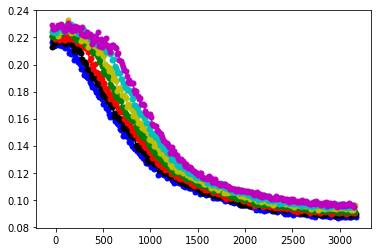

In [16]:
for plot_row in range(0, row):
    KEvPos = plt.figure(1)
    plt.plot(x_bin_arr[:, plot_row], temp_bin_arr[:, plot_row], marker = 'o', ms = 5, color = "bkrgycmbkrgycmbkrgycm"[plot_row])

In [17]:
final_values_arr = make_array(final_values)

In [18]:
time = np.asarray([1.0, 1.4, 1.8, 2.2, 2.6, 3.0, 3.4, 3.8]) #ns

The velocity in angstroms per nanosecond is: 147.7056556710766


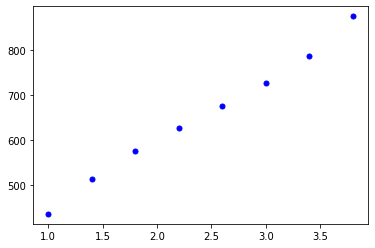

In [19]:
for row2 in range(0, len(final_values)):
    VelPlt = plt.figure(2)
    plt.plot(time[row2], final_values[row2], marker = 'o', ms = 5, color = "b")

m = return_slope(time, final_values_arr)
print('The velocity in angstroms per nanosecond is: {}'.format(m))